In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = pd.read_csv("/Users/shubhamgandhi/Desktop/aml/Churn-Prediction/preprocessed_with_smote.csv")
data_cleaned = data.drop([], axis=1)

X = data_cleaned.drop("Exited", axis=1)
y = data_cleaned["Exited"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

random_forest = RandomForestClassifier( n_estimators=100)
gboost = GradientBoostingClassifier( n_estimators=100)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stack_train_list = []  
stack_test = pd.DataFrame()
stack_test_preds = []

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_valid = X_train[train_idx], X_train[valid_idx]
    y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    random_forest.fit(X_fold_train, y_fold_train)
    gboost.fit(X_fold_train, y_fold_train)
    
    stack_train_list.append(pd.DataFrame({
        "rf_pred": random_forest.predict_proba(X_fold_valid)[:, 1],
        "gboost_pred": gboost.predict_proba(X_fold_valid)[:, 1],
        "target": y_fold_valid.values
    }))
    
    stack_test_preds.append({
        "rf_pred": random_forest.predict_proba(X_test)[:, 1],
        "gboost_pred": gboost.predict_proba(X_test)[:, 1],
    })

stack_train = pd.concat(stack_train_list, ignore_index=True)

stack_test["rf_pred"] = sum([pred["rf_pred"] for pred in stack_test_preds]) / len(stack_test_preds)
stack_test["gboost_pred"] = sum([pred["gboost_pred"] for pred in stack_test_preds]) / len(stack_test_preds)

X_meta = stack_train[["rf_pred", "gboost_pred"]]
y_meta = stack_train["target"]

logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_meta, y_meta)

meta_test_preds = logistic_regression.predict_proba(stack_test)[:, 1]
meta_test_labels = (meta_test_preds > 0.5).astype(int)

stacked_accuracy = accuracy_score(y_test, meta_test_labels)
print(f"Stacked Model Accuracy: {stacked_accuracy:.2%}")

Stacked Model Accuracy: 89.05%


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2389
           1       0.89      0.89      0.89      2389

    accuracy                           0.89      4778
   macro avg       0.89      0.89      0.89      4778
weighted avg       0.89      0.89      0.89      4778

Confusion Matrix:
[[2122  267]
 [ 256 2133]]


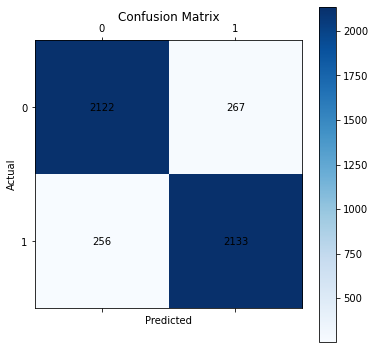

ROC AUC Score: 0.95


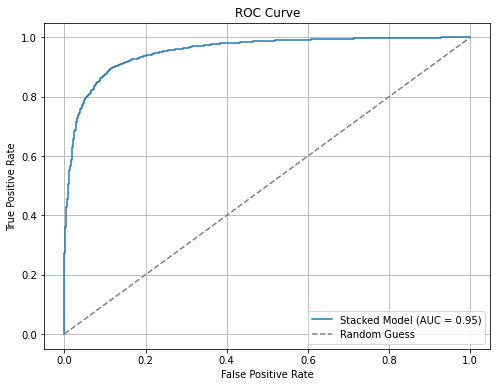

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

print("Classification Report:")
print(classification_report(y_test, meta_test_labels))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, meta_test_labels)
print(conf_matrix)

plt.figure(figsize=(6, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.title("Confusion Matrix", pad=20)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(j, i, f"{value}", ha="center", va="center")
plt.show()

roc_auc = roc_auc_score(y_test, meta_test_preds)
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, meta_test_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Stacked Model (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()